# NICE Challenge

### Importing the data

#### Note: I had to delete an extra character in the ID column name on the csv, since this was giving me encoding errors.

In [1]:
import pandas as pd
data = pd.read_csv('ChicagoCrimeData-master\Chicago_Crime_2013_2015.csv', parse_dates = ['Date'])
data

,ID,Case.Number,Date,Block,IUCR,Primary.Type,Description,Location.Description,Arrest,Domestic,...,Ward,Community.Area,FBI.Code,X.Coordinate,Y.Coordinate,Year,Updated.On,Latitude,Longitude,Location
0,10124853,HY313560,2015-06-23 23:50:00,024XX S KEDVALE AVE,820,THEFT,$500 AND UNDER,STREET,False,False,...,22.0,30.0,6,1149248.0,1887712.0,2015,6/30/2015 12:40,41.847805,-87.727747,"(41.84780493, -87.727747291)"
1,10124960,HY313663,2015-06-23 23:45:00,051XX S WENTWORTH AVE,454,BATTERY,AGG PO HANDS NO/MIN INJURY,POLICE FACILITY/VEH PARKING LOT,True,False,...,3.0,37.0,08B,1175865.0,1871146.0,2015,6/30/2015 12:40,41.801790,-87.630560,"(41.801789811, -87.630559815)"
2,10124917,HY313603,2015-06-23 23:42:00,049XX W RACE AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSS OF HANDGUN,APARTMENT,True,False,...,37.0,25.0,15,1143419.0,1903252.0,2015,6/30/2015 12:40,41.890559,-87.748752,"(41.890559483, -87.748751767)"
3,10124869,HY313604,2015-06-23 23:42:00,049XX W RACE AVE,2027,NARCOTICS,POSS: CRACK,APARTMENT,True,False,...,37.0,25.0,18,1143419.0,1903252.0,2015,6/30/2015 12:40,41.890559,-87.748752,"(41.890559483, -87.748751767)"
4,10124873,HY313566,2015-06-23 23:40:00,070XX S STATE ST,496,BATTERY,AGGRAVATED DOMESTIC BATTERY: KNIFE/CUTTING INST,SIDEWALK,False,True,...,6.0,69.0,04B,1177469.0,1858544.0,2015,6/30/2015 12:40,41.767173,-87.625058,"(41.767172506, -87.625058064)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697012,9103032,HW247232,2013-01-01 00:00:00,007XX W SCHUBERT AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,APARTMENT,False,False,...,43.0,7.0,11,1171019.0,1918449.0,2013,4/26/2013 11:02,41.931700,-87.646945,"(41.931700156, -87.646944847)"
697013,9372459,HW515117,2013-01-01 00:00:00,063XX S CALIFORNIA AVE,1120,DECEPTIVE PRACTICE,FORGERY,CURRENCY EXCHANGE,False,False,...,15.0,66.0,10,1158757.0,1862683.0,2013,11/7/2013 15:34,41.778933,-87.693533,"(41.778932885, -87.693532699)"
697014,9101785,HW245940,2013-01-01 00:00:00,065XX S WOLCOTT AVE,842,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,...,15.0,67.0,6,1164848.0,1861390.0,2013,4/30/2013 14:04,41.775258,-87.671239,"(41.775258194, -87.671238978)"
697015,9314160,HW458190,2013-01-01 00:00:00,052XX W CONGRESS PKWY,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,True,...,29.0,25.0,17,1141641.0,1897223.0,2013,9/27/2013 6:12,41.874048,-87.755431,"(41.874048209, -87.755430622)"


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697017 entries, 0 to 697016
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    697017 non-null  int64         
 1   Case.Number           697017 non-null  object        
 2   Date                  697017 non-null  datetime64[ns]
 3   Block                 697017 non-null  object        
 4   IUCR                  697017 non-null  object        
 5   Primary.Type          697017 non-null  object        
 6   Description           697017 non-null  object        
 7   Location.Description  696771 non-null  object        
 8   Arrest                697017 non-null  bool          
 9   Domestic              697017 non-null  bool          
 10  Beat                  697017 non-null  int64         
 11  District              690803 non-null  float64       
 12  Ward                  697011 non-null  float64       
 13 

#### Note: Due to time constraints, I will not perform EDA.

## Feature Engineering

I need to group the data by week. Each row is going to represent a week, where I create features to capture the behavior of each community. The targer variable is going to be the number of incidents per week. This way, I can grab the prior week, and this is going to generate a prediction of how many crimes there will be next week. 

In [7]:
df = data[data.Date.between('2013','12/27/2014')].groupby([pd.Grouper(key='Date', freq='W-SAT'), 'Community.Area'])['Case.Number'].count().reset_index()
df

,Date,Community.Area,Case.Number
0,2013-01-05,1.0,53
1,2013-01-05,2.0,52
2,2013-01-05,3.0,54
3,2013-01-05,4.0,27
4,2013-01-05,5.0,16
...,...,...,...
8008,2014-12-27,73.0,52
8009,2014-12-27,74.0,12
8010,2014-12-27,75.0,28
8011,2014-12-27,76.0,30


I will approach this problem as a multivariate time series forecasting. I will create a new dataframe that better reflects the shape I need:

In [8]:
column_list = list(df.groupby('Date').count().index)
index_list = [x for x in range(1,78,1)]

In [9]:
train = pd.DataFrame(index=index_list, columns = column_list)

In [10]:
for i in index_list:    
    train.loc[i,:] = df[df['Community.Area']==i]['Case.Number'].to_list()
train

,2013-01-05,2013-01-12,2013-01-19,2013-01-26,2013-02-02,2013-02-09,2013-02-16,2013-02-23,2013-03-02,2013-03-09,...,2014-10-25,2014-11-01,2014-11-08,2014-11-15,2014-11-22,2014-11-29,2014-12-06,2014-12-13,2014-12-20,2014-12-27
1,53,89,84,76,107,72,93,82,98,67,...,75,83,75,70,51,56,62,49,56,43
2,52,82,74,61,79,53,58,55,63,67,...,56,64,65,60,58,60,63,67,52,37
3,54,75,74,66,72,79,92,83,83,89,...,90,70,77,63,63,45,59,67,57,46
4,27,35,45,46,44,32,42,36,45,43,...,34,29,36,42,41,18,32,31,38,34
5,16,33,34,36,39,21,33,20,38,31,...,45,24,31,27,25,24,36,30,29,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,58,69,78,71,64,65,66,60,74,65,...,58,61,46,46,51,62,72,39,60,52
74,10,9,11,8,9,8,11,13,12,6,...,15,11,13,14,9,7,6,14,10,12
75,33,36,41,32,33,40,42,48,61,38,...,44,32,39,32,38,32,35,40,41,28
76,28,35,39,39,50,39,31,32,37,38,...,31,33,22,28,27,38,38,28,34,30


In [11]:
train.reset_index(inplace=True)
train.rename(columns={'index':'area'},inplace=True)

In [12]:
train = train.melt(id_vars='area', var_name = 'week', value_name='crimes')

In [13]:
foo = {}
for i,week in enumerate(train.week.unique()):
    foo[week] = i

In [14]:
train.replace({'week':foo}, inplace=True)

Actually, I will do a little bit of EDA. Let's do a little bit of time series analysis:

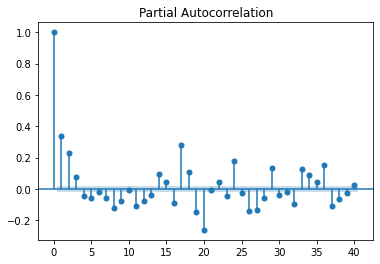

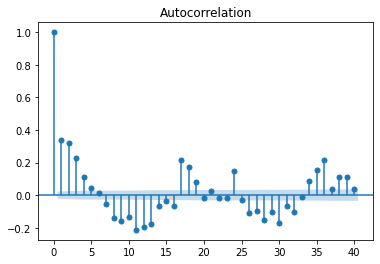

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plot_pacf(train['crimes'])
plot_acf(train['crimes'])
plt.show()

Here, I looked at the partial autocorrelation and autocorelation of the number of crimes on a week-to-week basis. The autocorrelation plot shows a possible seasonality in the data. Due to the time limit, I will not do a deeper analysis and will take the basic components of a time series: 1 week lag, the difference from previos week, and rolling average of the last 4 weeks (since we want to predict the first 4 weeks of March 2015)


In [16]:
#Splitting the dataset for train and test 
split_point = 80
test = train[train['week'] >= split_point].copy()
train = train[train['week'] < split_point].copy()

In [17]:
train

,area,week,crimes
0,1,0,53
1,2,0,52
2,3,0,54
3,4,0,27
4,5,0,16
...,...,...,...
6155,73,79,64
6156,74,79,10
6157,75,79,38
6158,76,79,29


In [18]:
# Create next_week variable (my targer variable)
train['next_week'] = train.groupby('area')['crimes'].shift(-1)
train.dropna(inplace=True)

In [19]:
# Create week_lag
train['lag_week'] = train.groupby('area')['crimes'].shift(1)

In [20]:
# Create week_diff
train['diff_week'] = train.groupby('area')['crimes'].diff()

In [21]:
# Create rolling avg of the last 4 weeks
train['rolling_4'] = train.groupby('area')['crimes'].rolling(4).mean().reset_index(level=0, drop=True)

Here, I will just drop all the null values. In a real-world project, I would explore the different metrics I get with different types of imputation methods.

In [22]:
train.dropna(inplace=True)

In [23]:
train = train.astype({'crimes':'float',
    'next_week':'float',
    'lag_week':'float',
    'diff_week':'float',
    'rolling_4':'float'})

In [24]:
y_pred = train['crimes']
y_true = train['next_week']

In [25]:
from sklearn.metrics import r2_score, mean_squared_error
print(mean_squared_error(y_true, y_pred))
print(r2_score(y_true,y_pred))

206.852016404648
0.9492832673193243


In [26]:
# Create function to apply the same procedure to the test data

def features(df):

    # Create next_week variable (my targer variable)
    df['next_week'] = df.groupby('area')['crimes'].shift(-1)
    df.dropna(inplace=True)

    # Create week_lag
    df['lag_week'] = df.groupby('area')['crimes'].shift(1)

    # Create week_diff
    df['diff_week'] = df.groupby('area')['crimes'].diff()

    # Create rolling avg of the last 4 weeks
    df['rolling_4'] = df.groupby('area')['crimes'].rolling(4).mean().reset_index(level=0, drop=True)

    df.dropna(inplace=True)
    
    df = df.astype({'crimes':'float',
    'next_week':'float',
    'lag_week':'float',
    'diff_week':'float',
    'rolling_4':'float'})
    
    return df

In [27]:
# Function to prepare new data from the beginning
def data_prep(df):
    column_list = list(df.groupby('Date').count().index)
    index_list = [x for x in range(1,78,1)]
    train = pd.DataFrame(index=index_list, columns = column_list)
    for i in index_list:    
        train.loc[i,:] = df[df['Community.Area']==i]['Case.Number'].to_list()
    
    train.reset_index(inplace=True)
    train.rename(columns={'index':'area'},inplace=True)
    train = train.melt(id_vars='area', var_name = 'week', value_name='crimes')
    foo = {}
    for i,week in enumerate(train.week.unique()):
        foo[week] = i
    train.replace({'week':foo}, inplace=True)

    return features(train)



In [28]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(train.drop(columns='next_week'), train.next_week)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [29]:
test = features(test)

In [30]:
pred = clf.predict(test.drop(columns='next_week'))

In [31]:
print(mean_squared_error(test.next_week, pred))
print(r2_score(test.next_week, pred))

207.79312954545455
0.940669588987786


Here we can see a very small improvemnt in the metrics when comparing the baseline (this week predicts next week) vs the RandomForestRegressor. In a real-world setting, I would do hyperparameter tuning. I would also spend more time in the feature engineering. I would also try at least two other models, such as LinearRegression, OLS, Lasso, etc. I chose RandomForestRegressor because it tends to be one of the most robust models.

At this point, once the model/models are tuned, I would proceed to train it with all the training data.

In [32]:
df = data[data.Date.between('2013','12/27/2014')].groupby([pd.Grouper(key='Date', freq='W-SAT'), 'Community.Area'])['Case.Number'].count().reset_index()
df = data_prep(df)
clf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(df.drop(columns='next_week'), df.next_week)


RandomForestRegressor(n_jobs=-1, random_state=42)

Now, let's create the predictions for the first 4 weeks of March 2015, and then we will rank the results.


Since we the most weeks the use in our feature engineering are 4 weeks for the rolling average, I will use the previous 4 weeks to predict the target week:

In [ ]:
def march_pred(date):

    df = data_prep(data[data.Date.between('2015',date)].groupby([pd.Grouper(key='Date', freq='W-SAT'), 'Community.Area'])['Case.Number'].count().reset_index()).drop(columns='next_week')
    df = pd.DataFrame(clf.predict(df[df.week == 6]), index = range(1,78,1))
    df.index.name = 'Community'
    df = df.sort_values(0, ascending=False).reset_index()
    df['PREDICTED.RANK'] = [x for x in range(1,78,1)]
    df['Week'] = pd.to_datetime(date) + pd.Timedelta(days=1)
    return df[['Community', 'Week', 'PREDICTED.RANK']].sort_values('Community')

In [ ]:
march1 = march_pred('02/28/2015')
march2 = march_pred('03/7/2015')
march3 = march_pred('03/14/2015')
march4 = march_pred('03/21/2015')


In [ ]:
march1.append(march2).append(march3).append(march4).to_csv('March_2015_Rankings_[PACHECO]_[RONALD].csv')